# Trajectories

This notebook shows how to read and manipulate the trajectories in which the system's configurations are stored.

## Opening and handling a trajectory

A trajectory file can directly be read using the `Trajectory` class. Let's open our first trajectory file:

In [1]:
from partycls import Trajectory

traj = Trajectory('../data/kalj_N150.xyz')

A `Trajectory` object is iterable, and is composed of `System` objects (*i.e.* frames).

In [2]:
# Number of frames in the trajectory
print(len(traj))

101


The `first`, `last` and `step` parameters allow to slice the trajectory to read a subset of the frames:
* `first` is the index of the first frame to read (default is `0`) ;
* `last` is the index of the last frame to read (default is `None`, meaning it will read up to the last frame) ;
* `step` is the increment between two consecutive frames to read (default is `1`, meaning that every frame is read). Setting `step=2` means that every 2 frames only will be read ;

For example:

In [3]:
# Read the 10 first frames only
traj = Trajectory('../data/kalj_N150.xyz', first=0, last=9)
print(len(traj))

10


Now, let's have a look at the first frame:

In [4]:
print(traj[0])

System(number_of_particles=150, species=['A' 'B'], chemical_fractions=[0.8 0.2], cell=[5. 5. 5.])


This tells us about the main features of the system. In particular, our `System` is enclosed in an orthorombic simulation cell. By default, periodic boundary conditions are assumed.

In [5]:
print(traj[0].cell)

Cell(side=[5. 5. 5.], periodic=[ True  True  True], volume=125.0)


The code accepts both 2- and 3-dimensional systems. The spatial dimension is guessed from the number of sides the cell has in the input file.

A `System` is composed of particles, accessible via the iterable`particle` attribute:

In [6]:
print(traj[0].particle[0])

Particle(position=[ 0.819926 -1.760086  0.36845 ], species=A, label=-1, radius=0.5, index=139812834853552, species_id=1)


Particles have several attributes, such as: 
- A position vector ; 
- A species (chemical symbol or type) ;
- A radius (by default set to `0.5`, needed for visualization purposes) ;
- A label, which is the index of the cluster that particle belongs to. Its default value is `-1` but it is automatically assigned after a clustering as we will see in the **Workflow** notebook ;
- An index, which is a unique integer value to identify the particle ;

In [7]:
p = traj[0].particle[0]

print('Position :', p.position)
print('Species :', p.species)
print('Radius :', p.radius, '(default)')
print('Label :', p.label)
print('Index :', p.index)

Position : [ 0.819926 -1.760086  0.36845 ]
Species : A
Radius : 0.5 (default)
Label : -1
Index : 139812834853552


We can assign arbitrary properties to a particle

In [8]:
p.mass = 0.5
print(p)

Particle(position=[ 0.819926 -1.760086  0.36845 ], species=A, label=-1, radius=0.5, index=139812834853552, species_id=1, mass=0.5)


All these properties can also be accessed via the method `get_property` (also called `dump` for short), either from `System` or `Trajectory` :
* For a  `System`, this will return a numpy array:

In [9]:
# Positions of all the particles in the first frame
pos_0 = traj[0].get_property('position')
# Show the positions of the 5 first particles
print(pos_0[0:5])

[[ 0.819926 -1.760086  0.36845 ]
 [ 0.29098   1.24579  -2.495344]
 [ 2.484607  0.35245   1.371003]
 [-1.02062  -1.927986  0.663132]
 [-0.816276  2.062004  0.421107]]


* For a `Trajectory`, this will return a list of numpy arrays with length `len(traj)`:

In [10]:
all_pos = traj.get_property('position')
print(len(all_pos))
# Positions in the first frame is the first element of the dumped list
print(all_pos[0][0:5])

10
[[ 0.819926 -1.760086  0.36845 ]
 [ 0.29098   1.24579  -2.495344]
 [ 2.484607  0.35245   1.371003]
 [-1.02062  -1.927986  0.663132]
 [-0.816276  2.062004  0.421107]]


This method accepts aliases for common particle properties, such as the position of the species:

In [11]:
# Use "dump" instead of "get_property" (equivalent)
pos_0 = traj[0].dump('pos')
x_0 = traj[0].dump('x') # x position only
spe_0 = traj[0].dump('spe')

print(pos_0[0:5])
print(x_0[0:5])
print(spe_0[0:5])

[[ 0.819926 -1.760086  0.36845 ]
 [ 0.29098   1.24579  -2.495344]
 [ 2.484607  0.35245   1.371003]
 [-1.02062  -1.927986  0.663132]
 [-0.816276  2.062004  0.421107]]
[ 0.819926  0.29098   2.484607 -1.02062  -0.816276]
['A' 'A' 'A' 'A' 'A']


However, any other additional particle property should be accessed using the following syntax:

`dump('particle.property')`

where `property` is the name of the corresponding particle property, *e.g.* `particle.mass`, `particle.radius`, etc. Be sure that this property is defined for **all** the particles before calling the  `dump` method (*e.g.* this is not the case here for the `mass` property that was defined for one particle only).

The `set_property`/`dump` method also works for cell properties. No aliases are accepted, so it must always be in the form of `'cell.property'`:

In [12]:
# Volumes of the cells for all the frames in the trajectory
print('volumes :', traj.dump('cell.volume'))

volumes : [125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0]


It is also possible to get the properties of a given **subset of particles**, by specifying a `subset` parameter in the form of a condition:

In [13]:
# Positions of the particles on the left side of the box (x < 0.0)
left = traj[0].dump('pos', 'particle.position[0] < 0.0')
print(left[0:10])

# Positions of the particles on the right side of the box (x > 0.0)
#  (use an alias for the x position)
right = traj[0].dump('pos', 'x > 0.0')
print('\n', right[0:10])

[[-1.02062  -1.927986  0.663132]
 [-0.816276  2.062004  0.421107]
 [-0.32223   0.751391 -1.607461]
 [-1.595135  2.262852 -1.671871]
 [-2.174664  0.643808 -1.462404]
 [-0.700083 -1.346258  2.163989]
 [-2.180021  1.253083 -0.613079]
 [-1.513521 -1.463041 -1.99653 ]
 [-1.050631 -0.873367  0.633333]
 [-0.575498 -0.407806 -0.43532 ]]

 [[ 0.819926 -1.760086  0.36845 ]
 [ 0.29098   1.24579  -2.495344]
 [ 2.484607  0.35245   1.371003]
 [ 1.890651 -0.623108 -0.60892 ]
 [ 1.046703  0.46165   2.148453]
 [ 2.102494  2.077016 -0.048818]
 [ 0.162451  1.761205  0.442532]
 [ 1.956404  2.423274 -2.307274]
 [ 0.961139  2.295941  0.567796]
 [ 1.311121 -0.526285 -1.422479]]


**N.B.** the `subset` parameter only concerns particle properties. It will be ignored when dumping a cell property.

Finally, some properties of our `System`:

In [14]:
sys = traj[0]

print('Number of spatial dimensions :', sys.n_dimensions)
print('Number of particles :', len(sys.particle))
print('Density :', sys.density)
print('Distinct species :', sys.distinct_species)
print('Chemical fractions :', sys.chemical_fractions)
print('Pairs of species :', sys.pairs_of_species)
print('Pairs of species ID :', sys.pairs_of_species_id)

Number of spatial dimensions : 3
Number of particles : 150
Density : 1.2
Distinct species : ['A' 'B']
Chemical fractions : [0.8 0.2]
Pairs of species : [('A', 'A'), ('A', 'B'), ('B', 'A'), ('B', 'B')]
Pairs of species ID : [(1, 1), (1, 2), (2, 1), (2, 2)]


The very last property, `pairs_of_species_id`, allows us to standardize the species in the trajectory, from a literal name or symbol to an integer value. Here, for example, we have:
- `"A"` --> `1`
- `"B"` --> `2`

In more complex cases, for instance when dealing with atomic symbols such as `"Si"`, `"C"`, `"O"`, etc., this standardization can come in handy.

## Dealing with different trajectory formats

Natively, the code only reads/write standard [XYZ](https://en.wikipedia.org/wiki/XYZ_file_format) trajectories (with a `cell` attribute in the comment line) and [RUMD](http://rumd.org/) trajectories:

In [15]:
# Open a XYZ trajectory
#  default value for `fmt` is "xyz"
traj_xyz = Trajectory('../data/kalj_N150.xyz', fmt='xyz')
print(traj_xyz)

# Open a RUMD trajectory
traj_rumd = Trajectory('../data/kalj_N256_rho1.185_rumd.xyz.gz', fmt='rumd')
print(traj_rumd)

Trajectory(filename="../data/kalj_N150.xyz", number_of_frames=101)
Trajectory(filename="../data/kalj_N256_rho1.185_rumd.xyz.gz", number_of_frames=1)


However, it is possible to rely on external packages to read more formats such as [LAMMPS](https://lammps.sandia.gov/), [GROMACS](https://www.gromacs.org/), etc. or even your custom trajectory formats.

These two external packages are:
* [atooms](https://framagit.org/atooms/atooms), a Python framework for simulations of interacting particles ;
* [MDTraj](https://www.mdtraj.org/1.9.5/index.html), a Python library that allows users to manipulate molecular dynamics trajectories ;

With these dependencies properly installed in the Python environment, it is possible to use them as backend when creating an instance of `Trajectory`:

### Atooms

In [16]:
# Open a LAMMPS trajectory using atooms
traj = Trajectory('../data/lj_N256_rho1.0.atom', 
                  fmt='lammps', backend='atooms')

print('Number of frames :', len(traj))
print(traj[0])

Number of frames : 6
System(number_of_particles=256, species=['1'], chemical_fractions=[1.], cell=[6.3496 6.3496 6.3496])


When using `backend="atooms"`, the `fmt` parameter must be set to the right trajectory format to select the appropriate parser. This is indepedent of the file extension.

### MDTraj

When using `backend="mdtraj"`, however, the file extension is used to determine the correct format (the `fmt` parameter can thus be ignored).

In [17]:
# Open a PDB trajectory using MDTraj
traj = Trajectory('../data/frame0.pdb', backend='mdtraj')

print('Number of frames :', len(traj))
print(traj[0])

Number of frames : 501
System(number_of_particles=22, species=['C' 'H' 'N' 'O'], chemical_fractions=[0.27272727 0.54545455 0.09090909 0.09090909], cell=[1. 1. 1.])


An additional `top` parameter can be specified for trajectory files that require external topology information (see [MDTraj](https://www.mdtraj.org/1.9.5/index.html) documentation). This parameter is specific to MDTraj and will be ignored when using atooms or native formats.

## Dealing with additional particle properties

Some trajectory formats may contain additional particle properties (mass, radius, etc.). It is possible to read these properties from the file using the parameter `additional_fields` when creating an instance of `Trajectory`.

Let's consider a simple XYZ trajectory file called `traj_with_masses.xyz` with 2 frames and only 3 particles, as follows:

`
3
columns:id,pos,mass cell:1.0,1.0,1.0
A 0.1 0.0 0.0 0.5
B 0.0 0.1 0.0 0.25
B 0.0 0.0 0.1 0.25
3
columns:id,pos,mass cell:1.0,1.0,1.0
A 0.2 0.0 0.0 0.5
B 0.0 0.2 0.0 0.25
B 0.0 0.0 0.2 0.25
`

As long as the property is specified in the header, it can be read when opening the trajectory:

In [18]:
# Specifying an additional field
traj = Trajectory('../data/traj_with_masses.xyz', 
                  additional_fields=['mass'])

print(traj[0].particle[0])
print('Masses :', traj.dump('particle.mass'))

Particle(position=[0.1 0.  0. ], species=A, label=-1, radius=0.5, index=139812835987664, mass=0.5, species_id=1)
Masses : [array([0.5 , 0.25, 0.25]), array([0.5 , 0.25, 0.25])]


**Important:**

Not all trajectory formats and backends support additional fields.

When reading, the `additional_fields` parameter may then be ignored for some formats (only positions and species will be read). The same applies when writing a trajectory.

On that regard, the XYZ format is probably the most flexible, being natively supported by the code.

## Setting or modifying a particle property

As a counterpart for the method `set_property`, the method `set_property` allows to set or change a particle property trajectory-wide, for all particles or for a specific subset. This property can be either a scalar value, in which case it will be set to all the particles in the subset:

In [19]:
traj = Trajectory('../data/traj_with_masses.xyz', 
                  additional_fields=['mass'])

# Current `mass` property
print(traj.dump('particle.mass'))

# Change it for all the particles
traj.set_property('mass', 1.0)
print(traj.dump('particle.mass'))

# Change it for a given subset
traj.set_property('mass', 0.75, subset="species == 'B'")
print(traj.dump('particle.mass'))

[array([0.5 , 0.25, 0.25]), array([0.5 , 0.25, 0.25])]
[array([1., 1., 1.]), array([1., 1., 1.])]
[array([1.  , 0.75, 0.75]), array([1.  , 0.75, 0.75])]


The property can also be a `list` or a `numpy.ndarray` that will be mapped to the particles (*i.e.* set values element by element). This is convenient if this property is read from another file or computed elsewhere in your code.

In this case, the parameter should have the right shape: same number of frames than the trajectory, and same number of particles than the considered subset:

In [20]:
# 2 frames, 3 particles (same as the trajectory)
masses = [[0.5, 0.25, 0.25],
          [0.6, 0.35, 0.35]]
traj.set_property('mass', masses)
print(traj.dump('particle.mass'))

# 2 frames, 2 particles 
#  (because there are only B particles in the subset)
masses = [[0.23, 0.34],
          [0.56, 0.67]]
traj.set_property('mass', masses, "species == 'B'")
print(traj.dump('particle.mass'))

[array([0.5 , 0.25, 0.25]), array([0.6 , 0.35, 0.35])]
[array([0.5 , 0.23, 0.34]), array([0.6 , 0.56, 0.67])]


A property can also be set for a specific frame:

In [21]:
traj[0].set_property('mass', 0.75)
traj[1].set_property('mass', [0.15, 0.25, 0.35])
print(traj.dump('mass'))

[array([0.75, 0.75, 0.75]), array([0.15, 0.25, 0.35])]


The property can also be a new property that the particles do not have yet:

In [22]:
# Set a new property
energies = [[0.51, 0.43, 0.37],
            [0.55, 0.44, 0.41]]
traj.set_property('energy', energies)
print(traj.dump('particle.energy'))

[array([0.51, 0.43, 0.37]), array([0.55, 0.44, 0.41])]


As mentioned above, it is crucial that the property is defined for all particles when calling the `dump` method or when applying a filter on a structural descriptor (see the **Descriptors** notebook).

## Visualizing a trajectory

Simple and customizable visualization methods allow to display the trajectory frames using the `Trajectory.show` method. Currently supported visualization backends are `matplotlib`, `ovito` and  `3dmol`. The specified `backend` argument of the `Trajectory.show` method thus calls a backend-dependent function (`partycls.helpers` for more information).

**N.B.** If a `radius` property is defined for the particles, this will display the particles accordingly. If not, this will use a default value for all the particles.

### Matplotlib

*(See the `show_matplotlib` function in `partycls.helpers` for more information)*

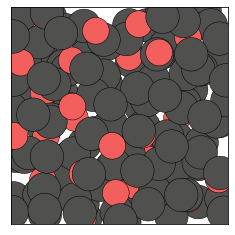

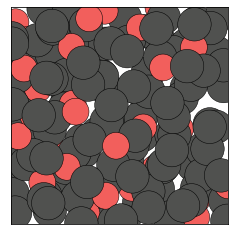

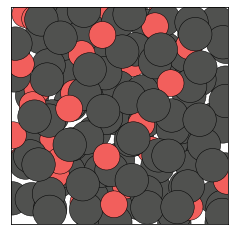

In [23]:
# open a trajectory file
traj = Trajectory('../data/kalj_N150.xyz')
# adjust radii
traj.set_property('radius', 0.5, "species == 'A'")
traj.set_property('radius', 0.4, "species == 'B'")

# show the first three frames
# (all frames are shown if `frames` is not specified)
# default coloring code uses the species
figs = traj.show(frames=[0,1,2], backend='matplotlib', show=True)

The `Trajectory` class being iterable, one can also show a specific frame by calling `show` on an element of the trajectory:

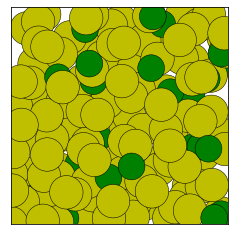

In [24]:
# show the 5-th frame, change the view, use custom colors
fig = traj[4].show(backend='matplotlib', view='back',
                   palette=['y', 'g'], show=True)

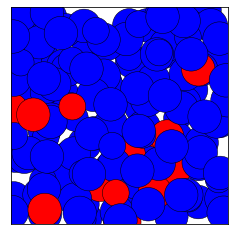

In [25]:
# color particles according to an arbitrary *discrete* particle property
# (for the example, we randomly assign labels to the particles)
traj[0].set_property('label', 0)
p = [0,15,28,37,41,56,63,72,88,90,104,113,125,137,142]
for pi in p:
    traj[0].particle[pi].label = 1
fig = traj[0].show(color='label', palette=['b', 'r'], show=True)

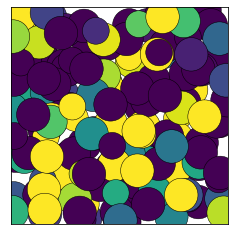

In [26]:
# color particles according to an arbitrary *continuous* particle property
# (for the example, we randomly assign a random float property to the particles)
from numpy.random import normal
rn = [normal() for i in range(150)]
traj[0].set_property('random', rn)
fig = traj[0].show(color='random', cmap='viridis', show=True)

### Ovito

*(See the `show_ovito` function in `partycls.helpers` for more information)*

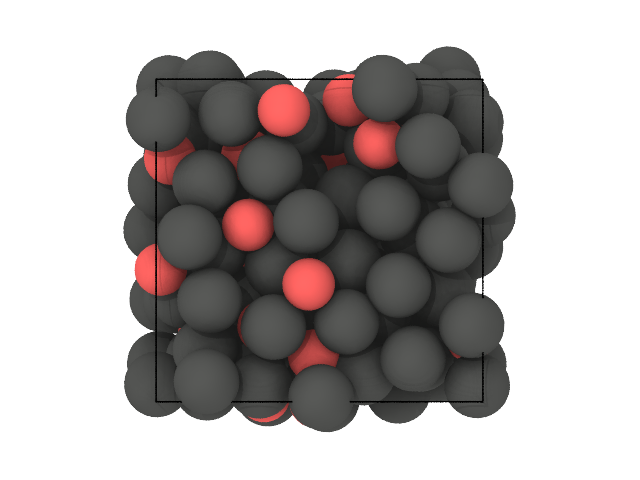

In [27]:
from partycls.trajectory import Trajectory

# open a trajectory file
traj = Trajectory('../data/kalj_N150.xyz')
# adjust radii
traj.set_property('radius', 0.5, "species == 'A'")
traj.set_property('radius', 0.4, "species == 'B'")

# show the first frame
traj[0].show(backend='ovito')

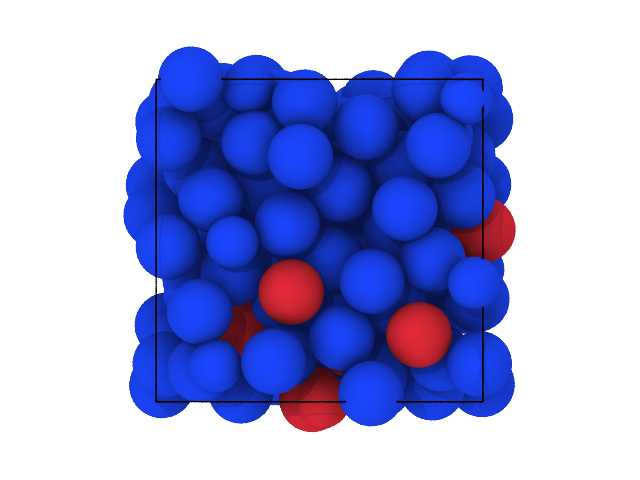

In [28]:
# color particles according to an arbitrary *discrete* particle property
# (for the example, we randomly assign labels to the particles)
traj[0].set_property('label', 0)
p = [0,15,28,37,41,56,63,72,88,90,104,113,125,137,142]
for pi in p:
    traj[0].particle[pi].label = 1
    
# /!\ colors must be in RGB format
ovito_colors = [(0.1,0.25,0.9), (0.8,0.15,0.2)]

# show the first frame
traj[0].show(color='label', backend='ovito', palette=ovito_colors, view='bottom')

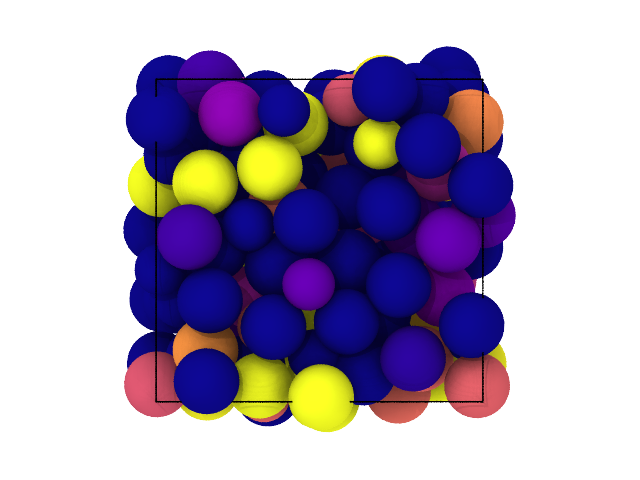

In [29]:
# color particles according to an arbitrary *continuous* particle property
# (for the example, we randomly assign a random float property to the particles)
from numpy.random import normal
rn = [normal() for i in range(150)]
traj[0].set_property('random', rn)
traj[0].show(color='random', backend='ovito', cmap='plasma')

### py3Dmol

*(See the `show_3dmol` function in `partycls.helpers` for more information)*

In [30]:
# open a trajectory file
traj = Trajectory('../data/dislocation.xyz')

# show the first frame
# default coloring code uses the species
view = traj[0].show(backend='3dmol')
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [31]:
# color particles according to an arbitrary *discrete* particle property
# (for the example, we randomly assign labels to the particles)
traj[0].set_property('label', 0)
p = [0,5,11,16,20]
for pi in p:
    traj[0].particle[pi].label = 1
view = traj[0].show(backend='3dmol', color='label', palette=['blue', 'red'])
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

**N.B.** the py3Dmol backend works well with small systems, but it tends to get pretty slow with larger systems.

## Writing a trajectory

The class `Trajectory` can also write a trajectory file thanks to the `write` method. Once the input trajectory has been loaded at the creation of a `Trajectory` object, every communication with the original file is over: changing the current instance of `Trajectory` will have no effect on the original file.

Writing a new trajectory file from the current instance can then be useful for many reasons. For example, convert from a format to another:

In [32]:
# Open XYZ file
traj = Trajectory('../data/traj_with_masses.xyz')

# Write the trajectory in RUMD format (as a new file)
traj.write('../data/traj_with_masses.xyz.gz', fmt='rumd')

Other example, write a trajectory file with additional fields that were not present in the original file:

In [33]:
# Open XYZ file
traj = Trajectory('../data/traj_with_masses.xyz', additional_fields=['mass'])

# Set custom values for radii of the particles
traj.set_property('radius', 0.5, "species == 'A'")
traj.set_property('radius', 0.4, "species == 'B'")

# Write a new file with both masses and radii
traj.write('../data/traj_with_masses_and_radii.xyz', fmt='xyz', additional_fields=['mass', 'radius'])